Hello this kernel is a work in process.I will be doing an exploratory data analysis and Crime forecasting in this data set.I will be updating this kernel in coming days.If you like my work please do vote.

In [1]:
#!conda install -c conda-forge fbprophet -y
#!pip install folium
#!pip install pystan
#!pip install seaborn

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./forecasting_dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./forecasting_dataset\2015.csv
./forecasting_dataset\2016.csv
./forecasting_dataset\2017.csv
./forecasting_dataset\2018.csv


#### Importing Python Modules 

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
import folium
from folium.plugins import HeatMap
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [48]:
data=pd.read_csv('./forecasting_dataset/2015.csv',encoding='UTF-8')

In [49]:
data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,STREET,Lat,Long,Location
0,I182066132,2629,Harassment,HARASSMENT,B3,31/07/2015 23:27,2015,7,Friday,23,RADCLIFFE ST,42.300202,-71.078354,"(42.30020194, -71.07835353)"
1,I182054888,2647,Other,THREATS TO DO BODILY HARM,B2,12/07/2015 15:37,2015,7,Sunday,15,FAYSTON ST,42.312243,-71.075499,"(42.31224327, -71.07549901)"
2,I182052842,1102,Fraud,FRAUD - FALSE PRETENSE / SCHEME,D4,20/12/2015 14:00,2015,12,Sunday,14,WESTLAND AVE,42.343917,-71.089675,"(42.34391716, -71.08967541)"
3,I182052842,619,Larceny,LARCENY ALL OTHERS,D4,20/12/2015 14:00,2015,12,Sunday,14,WESTLAND AVE,42.343917,-71.089675,"(42.34391716, -71.08967541)"
4,I182044114,1107,Fraud,FRAUD - IMPERSONATION,E18,1/07/2015 12:00,2015,7,Wednesday,12,OAKCREST RD,42.264521,-71.104292,"(42.26452149, -71.10429211)"


In [50]:
data.shape

(51154, 14)

#### Renaiming the columns for convinence

In [51]:
data1 = data.rename(columns={'OFFENSE_CODE':'Code','OFFENSE_CODE_GROUP':'Group','OFFENSE_DESCRIPTION':'Description','OCCURRED_ON_DATE':'Date'})
data1.head()

,INCIDENT_NUMBER,Code,Group,Description,DISTRICT,Date,YEAR,MONTH,DAY_OF_WEEK,HOUR,STREET,Lat,Long,Location
0,I182066132,2629,Harassment,HARASSMENT,B3,31/07/2015 23:27,2015,7,Friday,23,RADCLIFFE ST,42.300202,-71.078354,"(42.30020194, -71.07835353)"
1,I182054888,2647,Other,THREATS TO DO BODILY HARM,B2,12/07/2015 15:37,2015,7,Sunday,15,FAYSTON ST,42.312243,-71.075499,"(42.31224327, -71.07549901)"
2,I182052842,1102,Fraud,FRAUD - FALSE PRETENSE / SCHEME,D4,20/12/2015 14:00,2015,12,Sunday,14,WESTLAND AVE,42.343917,-71.089675,"(42.34391716, -71.08967541)"
3,I182052842,619,Larceny,LARCENY ALL OTHERS,D4,20/12/2015 14:00,2015,12,Sunday,14,WESTLAND AVE,42.343917,-71.089675,"(42.34391716, -71.08967541)"
4,I182044114,1107,Fraud,FRAUD - IMPERSONATION,E18,1/07/2015 12:00,2015,7,Wednesday,12,OAKCREST RD,42.264521,-71.104292,"(42.26452149, -71.10429211)"


#### Finding the missing data 

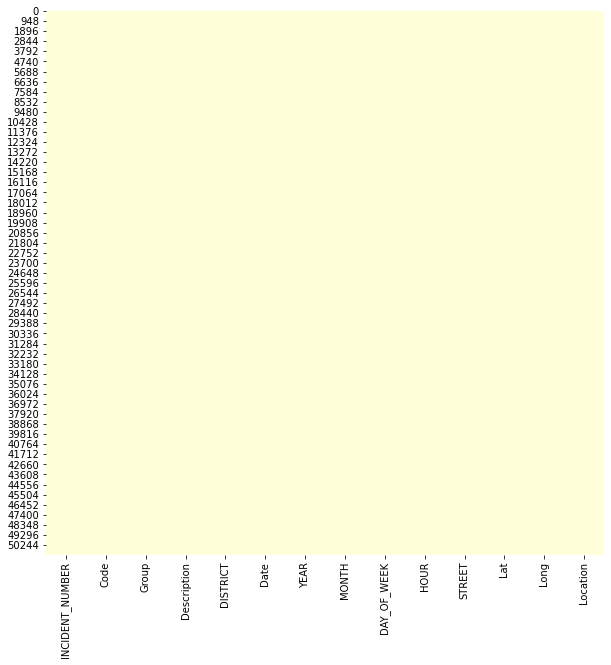

In [52]:
#!pip install seaborn
#!pip install --upgrade seaborn
plt.figure(figsize=(10,10))
sns.heatmap(data1.isnull(),cbar=False,cmap='YlGnBu')
plt.ioff()

All the horizontal lines show the missing data in the dataset.Let us clean up the missing data by dropping the columns with missing data.Also the columns getting dropped will not have an affect on the forecasting of the crime.

#### Dropping the unwanted columns

In [53]:
data1.drop(['INCIDENT_NUMBER','Code','Lat','Long','Location'],inplace=True,axis=1)
data1.head()

,Group,Description,DISTRICT,Date,YEAR,MONTH,DAY_OF_WEEK,HOUR,STREET
0,Harassment,HARASSMENT,B3,31/07/2015 23:27,2015,7,Friday,23,RADCLIFFE ST
1,Other,THREATS TO DO BODILY HARM,B2,12/07/2015 15:37,2015,7,Sunday,15,FAYSTON ST
2,Fraud,FRAUD - FALSE PRETENSE / SCHEME,D4,20/12/2015 14:00,2015,12,Sunday,14,WESTLAND AVE
3,Larceny,LARCENY ALL OTHERS,D4,20/12/2015 14:00,2015,12,Sunday,14,WESTLAND AVE
4,Fraud,FRAUD - IMPERSONATION,E18,1/07/2015 12:00,2015,7,Wednesday,12,OAKCREST RD


#### Arranging the date in datetime format

In [58]:
data1['Date']=pd.to_datetime(data1['Date'], dayfirst=True)
data1.head()

,Group,Description,DISTRICT,Date,YEAR,MONTH,DAY_OF_WEEK,HOUR,STREET
0,Harassment,HARASSMENT,B3,2015-07-31 23:27:00,2015,7,Friday,23,RADCLIFFE ST
1,Other,THREATS TO DO BODILY HARM,B2,2015-07-12 15:37:00,2015,7,Sunday,15,FAYSTON ST
2,Fraud,FRAUD - FALSE PRETENSE / SCHEME,D4,2015-12-20 14:00:00,2015,12,Sunday,14,WESTLAND AVE
3,Larceny,LARCENY ALL OTHERS,D4,2015-12-20 14:00:00,2015,12,Sunday,14,WESTLAND AVE
4,Fraud,FRAUD - IMPERSONATION,E18,2015-07-01 12:00:00,2015,7,Wednesday,12,OAKCREST RD


In [59]:
data1.Date

0       2015-07-31 23:27:00
1       2015-07-12 15:37:00
2       2015-12-20 14:00:00
3       2015-12-20 14:00:00
4       2015-07-01 12:00:00
                ...        
51149   2015-08-12 12:00:00
51150   2015-08-12 12:00:00
51151   2015-07-09 13:38:00
51152   2015-07-09 13:38:00
51153   2015-06-22 00:12:00
Name: Date, Length: 51154, dtype: datetime64[ns]

In [60]:
data1.index=pd.DatetimeIndex(data1.Date)
data1.head()

,Group,Description,DISTRICT,Date,YEAR,MONTH,DAY_OF_WEEK,HOUR,STREET
Date,,,,,,,,,
2015-07-31 23:27:00,Harassment,HARASSMENT,B3,2015-07-31 23:27:00,2015,7,Friday,23,RADCLIFFE ST
2015-07-12 15:37:00,Other,THREATS TO DO BODILY HARM,B2,2015-07-12 15:37:00,2015,7,Sunday,15,FAYSTON ST
2015-12-20 14:00:00,Fraud,FRAUD - FALSE PRETENSE / SCHEME,D4,2015-12-20 14:00:00,2015,12,Sunday,14,WESTLAND AVE
2015-12-20 14:00:00,Larceny,LARCENY ALL OTHERS,D4,2015-12-20 14:00:00,2015,12,Sunday,14,WESTLAND AVE
2015-07-01 12:00:00,Fraud,FRAUD - IMPERSONATION,E18,2015-07-01 12:00:00,2015,7,Wednesday,12,OAKCREST RD


#### Getting information most recurring Crime

In [61]:
data1['Group'].value_counts()

Motor Vehicle Accident Response    5297
Larceny                            4898
Other                              3243
Drug Violation                     3060
Medical Assistance                 3047
                                   ... 
Harbor Related Incidents              5
Aircraft                              4
Gambling                              2
INVESTIGATE PERSON                    1
Burglary - No Property Taken          1
Name: Group, Length: 62, dtype: int64

In [62]:
data1['Group'].value_counts().iloc[:15]

Motor Vehicle Accident Response    5297
Larceny                            4898
Other                              3243
Drug Violation                     3060
Medical Assistance                 3047
Vandalism                          2662
Simple Assault                     2514
Investigate Person                 2452
Larceny From Motor Vehicle         2040
Towed                              1539
Verbal Disputes                    1501
Property Lost                      1480
Residential Burglary               1414
Aggravated Assault                 1316
Warrant Arrests                    1234
Name: Group, dtype: int64

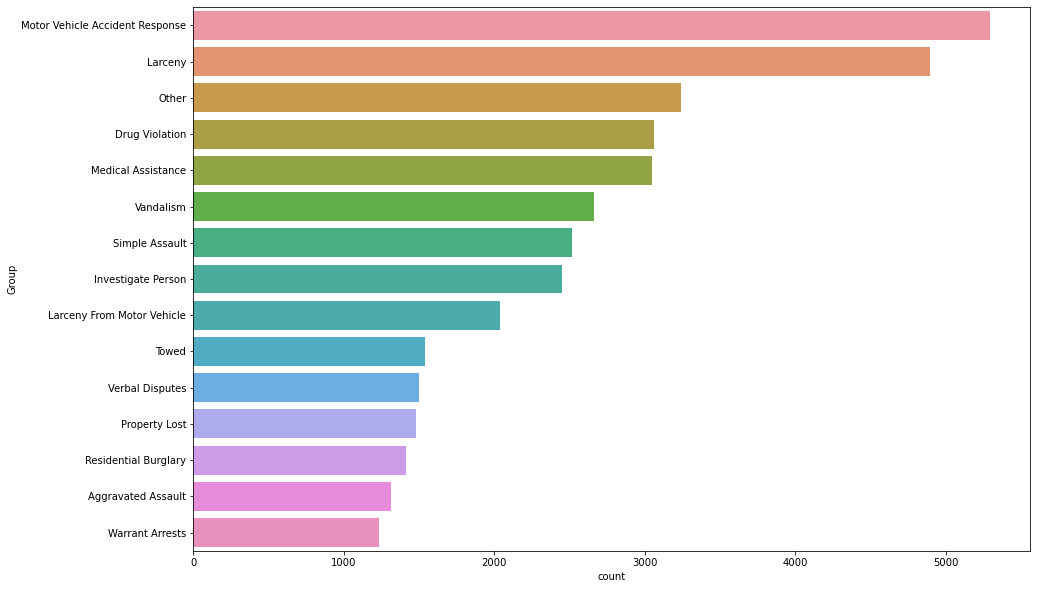

In [63]:
order_data=data1['Group'].value_counts().iloc[:15].index
plt.figure(figsize=(15,10))
sns.countplot(y='Group',data=data1,order=order_data)
plt.ioff()

So we can clearly see that the motor vehicle accident,theft and medical assistance are most crime indidents reported in Boston.

#### Resampling the data: 
This is done to segregate the crime count based on time period like month,quarter and year

In [64]:
data1.resample('Y').size()

Date
2015-12-31    51154
Freq: A-DEC, dtype: int64

In [65]:
#plt.plot(data1.resample('Y').size())
#plt.title('Crime Count Per Year')
#plt.xlabel('Years')
#plt.ylabel('Number of Crimes')
#plt.ioff()

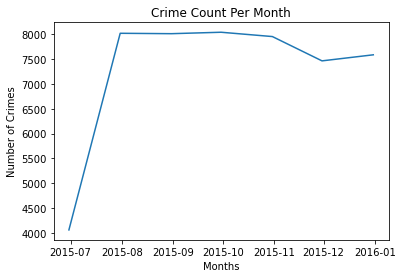

In [66]:
plt.plot(data1.resample('M').size())
plt.title('Crime Count Per Month')
plt.xlabel('Months')
plt.ylabel('Number of Crimes')
plt.ioff()

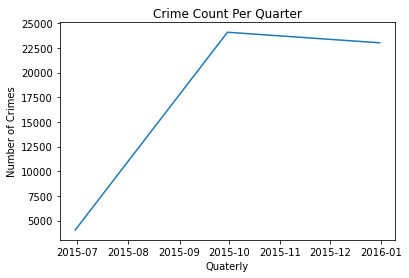

In [67]:
plt.plot(data1.resample('Q').size())
plt.title('Crime Count Per Quarter')
plt.xlabel('Quaterly')
plt.ylabel('Number of Crimes')
plt.ioff()

The X axis values and not getting displayed correctly.I am not sure why ? May be someone can throw some light on what needs to be done

#### Preparing the data 

In [68]:
Boston_prophet=data1.resample('M').size().reset_index()

In [69]:
Boston_prophet.head()

,Date,0
0,2015-06-30,4059
1,2015-07-31,8023
2,2015-08-31,8015
3,2015-09-30,8044
4,2015-10-31,7957


#### Renaming the columns of Boston_prophet

In [70]:
Boston_prophet.columns=['Date','Crime_Count']

In [71]:
Boston_prophet.head()

,Date,Crime_Count
0,2015-06-30,4059
1,2015-07-31,8023
2,2015-08-31,8015
3,2015-09-30,8044
4,2015-10-31,7957


In [72]:
Boston_prophet_final=Boston_prophet.rename(columns={'Date':'ds','Crime_Count':'y'})

In [73]:
Boston_prophet_final.head()

,ds,y
0,2015-06-30,4059
1,2015-07-31,8023
2,2015-08-31,8015
3,2015-09-30,8044
4,2015-10-31,7957


#### Make Predictions

In [110]:
#!pip install --upgrade holidays pystan
#!pip install pystan==2.19.1.1 prophet
#!pip install prophet
#!conda install -c conda-forge prophet -y
#from prophet import Prophet
m=Prophet(interval_width=0.95, daily_seasonality=True)
model = m.fit(Boston_prophet_final)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.


In [115]:
future=m.make_future_dataframe(periods=365, freq='D')
forecast=m.predict(future)

In [116]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-06-30,377.610583,4101.189659,8367.665542,377.610583,377.610583,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,0.0,0.0,0.0,6289.845752
1,2015-07-31,719.817857,4353.934645,8964.711172,719.817857,719.817857,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,0.0,0.0,0.0,6632.053026
2,2015-08-31,1062.025132,4815.493711,9157.575705,1062.025132,1062.025132,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,0.0,0.0,0.0,6974.260301
3,2015-09-30,1393.193463,5066.136880,9674.406261,1393.193463,1393.193463,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,0.0,0.0,0.0,7305.428632
4,2015-10-31,1735.400739,5484.038908,9903.043784,1735.400739,1735.400739,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,0.0,0.0,0.0,7647.635908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,2016-12-26,6393.835256,10114.006130,14661.434777,6393.834525,6393.835998,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,0.0,0.0,0.0,12306.070425
368,2016-12-27,6404.874200,10147.208720,14580.775716,6404.873467,6404.874946,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,0.0,0.0,0.0,12317.109370
369,2016-12-28,6415.913145,10001.299586,14414.481454,6415.912408,6415.913893,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,0.0,0.0,0.0,12328.148314
370,2016-12-29,6426.952089,10014.276600,14480.577877,6426.951349,6426.952840,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,5912.235169,0.0,0.0,0.0,12339.187258


In [117]:
predict_2016 = './predictions/2016_forecast.csv'
forecast.to_csv(predict_2016)


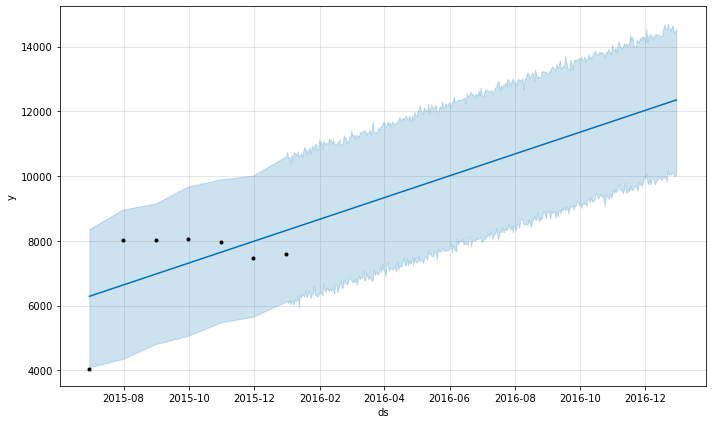

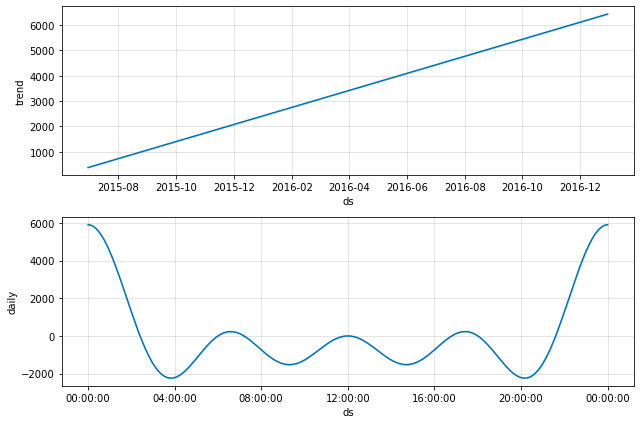

In [118]:
plot1 = m.plot(forecast)
plot2 = m.plot_components(forecast)